# Power Spectrum

## Power Spectrum as Function of $\phi_1$ 

### Import Data

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.signal import csd
import pandas as pd
from sympy import *
from sympy import symbols
from sympy import integrate
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatter
from IPython.display import display, Image
import io
import os
# from mpi4py import MPI

import power
import stream

### Import Data

In [2]:
# Retrieve environment variable num_data from bash-script
num_data = int(os.getenv("num_data", "0"))  # Default = 0

In [3]:
# Chose subhalo profile
subhalo_profile = 'SIDM5_sph'

In [4]:
# Import data from the stream simulation
simulation_data = pd.read_csv(f'../results/{subhalo_profile}/data_output_power_section{num_data}.csv')
phi_sim = simulation_data['x'].values

In [5]:
# Import data from the Ibata paper for the binning
data = pd.read_csv('../data/ibata/Ibata_Hist_Gaia.csv')
# count = data['y'].values
phi = data['x'].values

### Bin Data

In [6]:
# As default we use the binning of Ibata for both phi and s
# Set number of bins
n_bins = 40 

In [7]:
counts_phi, binning = power.binning(phi_sim, n_bins, min(phi), max(phi))

In [8]:
bin_size = power.calculate_bin_size_bins(min(phi), max(phi), n_bins)

### Fit Counts

In [9]:
# Set the error
x = np.array(binning)
y = np.array(counts_phi)
x_err = np.full_like(x, 1.0)  # Uncertainty for x
y_err = np.sqrt(y) # Uncertainty for y

In [10]:
# Import fitting function

params, quadratic_fit = power.quadratic_function(x, y, x_err, y_err)

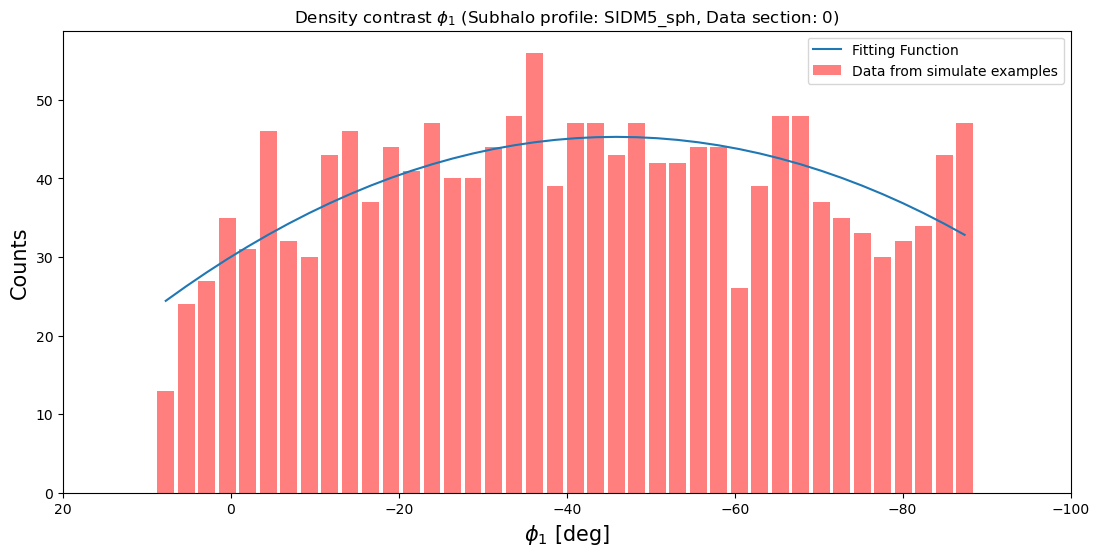

In [11]:
# Plot
plt.figure(figsize=(13,6))
plt.bar(binning, counts_phi,width=2, color='r',alpha=0.5, label = 'Data from simulate examples')
plt.plot(binning, quadratic_fit,label='Fitting Function')
plt.title(f'Density contrast $\phi_1$ (Subhalo profile: {subhalo_profile}, Data section: {num_data})')
# plt.plot(phi,fit_not_div,label='Fitting Function Ibata')
plt.xlim([20,-100])
plt.ylabel('Counts',size=15)
plt.xlabel(r'$\phi_1$ [deg]',size=15)
plt.legend()

# Save and show
plt.savefig(f'../results/{subhalo_profile}/density_contrast_phi1_section{num_data}.pdf')
plt.show()

### Calculate Power Spectrum

In [12]:
# Calculate density contrast
dens_fit = counts_phi/quadratic_fit

In [13]:
# Calculate power spectrum with csd
f_fit, pxx_fit = csd(dens_fit,dens_fit,fs=1/bin_size,scaling='spectrum',nperseg=n_bins)

In [14]:
# Inverse frequency
f_inv = 1/f_fit
# print(power)

/tmp/ipykernel_24378/1451415981.py:2: RuntimeWarning: divide by zero encountered in divide
  f_inv = 1/f_fit


### Plot and Save Power Spectrum

In [15]:
# Save values for band plot
# Normalise power by length of considered segment, following Bovy 
x = f_inv
y = 1 * np.sqrt(97.5 * np.array(pxx_fit))  

# Create data frame and save
data = pd.DataFrame({'x': x, 'y': y})
output_path = f'../results/{subhalo_profile}/power_spectrum_phi1_data_section{num_data}.csv'
data.to_csv(output_path, index=False)

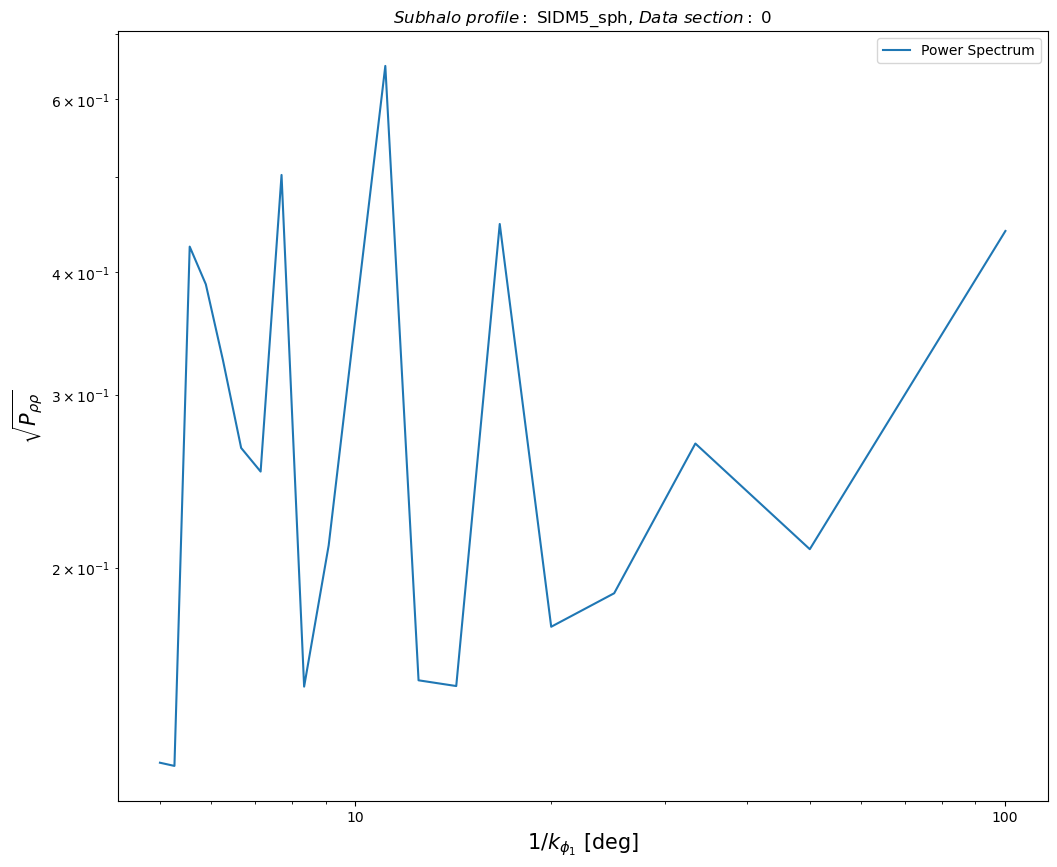

In [16]:
# Plot 
plt.figure(figsize=(12,10))
plt.loglog(x, y,label='Power Spectrum')

plt.ylabel(r'$\sqrt{P_{\rho\rho}}$',size=15)
plt.xlabel(r'$1/k_{\phi_1}$ [deg]',size=15)
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=True))
plt.legend()
plt.title(f'$Subhalo$ $profile:$ {subhalo_profile}, $Data$ $section:$ {num_data}')

# Save and show
plt.savefig(f'../results/{subhalo_profile}/power_spectrum_phi1_section{num_data}.pdf')
plt.show()

## Transformation from $\phi_1$ to s 

In this version of the code, we calculate D (and thus also s) directly from the galactocentric coordinates of every star.

### Load Positions of Stars

In [17]:
data = np.load(f'../results/{subhalo_profile}/stream_trajectories_section{num_data}.npz')
tr = data['tr']

In [18]:
num_stars = tr.shape[0]
print(num_stars)

2000


### Calculate Heliocentric Distance D from Galactocentric Coordinates

In [19]:
D = power.calculate_D_galactocentric(tr, rsun=[-8,0,0])

### Convert into Koposov GD-1 Frame

In [20]:
pos = stream.coordinates.transform(tr)

### Plot D as Function of $\phi_1$ and Fit

In [21]:
# Determine parameter with fitfunction
x = np.array(pos['phi1'])
y = np.array(D)
x_err = x_err = np.full_like(x, 1.0)
y_err = np.sqrt(y)

In [22]:
# Sort values for fit
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
x_err_sorted = x_err[sorted_indices]
y_err_sorted = y_err[sorted_indices]

In [23]:
params, quintic_fit = power.quintic_function(x_sorted, y_sorted, x_err_sorted, y_err_sorted)

In [24]:
# Determine coefficients for D as a function of phi1
a5, a4, a3, a2, a1, a0 = params
# print(a5, a4, a3, a2, a1, a0)

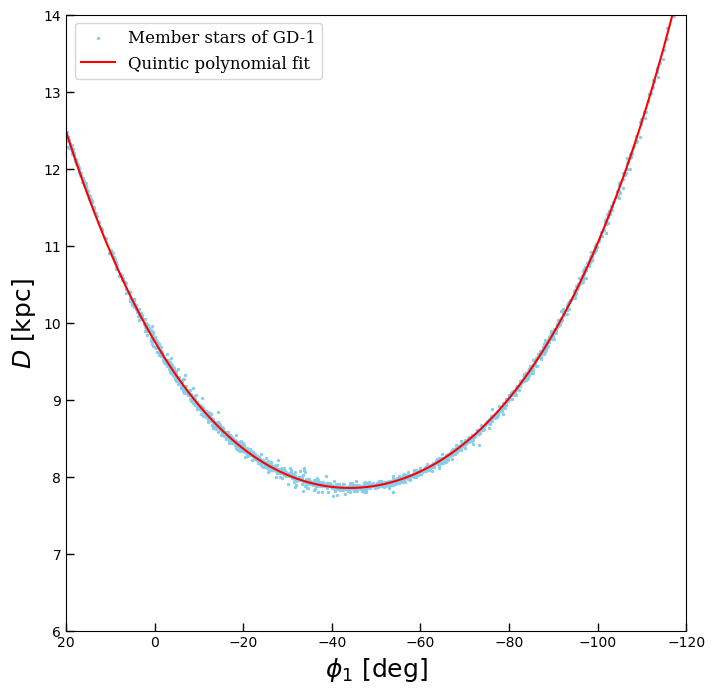

In [25]:
# Plot 
plt.figure(figsize=(8, 8))
plt.scatter(pos['phi1'], D, color='skyblue', s=8, marker='.', label='Member stars of GD-1')  
plt.plot(x_sorted, quintic_fit, label='Quintic polynomial fit', color='red')

# Title
plt.xlabel(r'$\phi_1$ [deg]', fontsize=18) 
plt.ylabel(r'$D$ [kpc]', fontsize=18)
plt.tick_params(axis='both', direction='in', length=6, width=1)

# Limits
plt.xlim(20, -120)  
plt.ylim(6, 14)     

# Legend
plt.legend(fontsize=16, prop={'family': 'serif', 'size': 12})

# Show and save
plt.savefig(f'../results/{subhalo_profile}/heliocentric_distance{num_data}.pdf')
plt.show()

### Perform Integration 

In [26]:
phi_rad = pos['phi1']*(np.pi/180)

In [27]:
s = power.perform_integration_galactocentric(phi_rad, a5, a4, a3, a2, a1, a0)

## Power Spectrum as Function of s 

### Bin Stars

In [28]:
# Use Ibata's binning
binning_lower_limit = -10.5
binning_upper_limit = 1.5

In [29]:
counts_s, binning_s = power.binning(s, n_bins, binning_lower_limit, binning_upper_limit)

In [30]:
bin_size_s = power.calculate_bin_size_bins(binning_lower_limit, binning_upper_limit, n_bins)

### Fit Counts

In [31]:
# Set the error
x = np.array(binning_s)
y = np.array(counts_s)
x_err = np.full_like(x, 1.0)  # Uncertainty for x
y_err = np.sqrt(y) # Uncertainty for y
# x_err = 1.0
# y_err = 1.0

In [32]:
# Import fitting function
params, quadratic_fit = power.quadratic_function(x, y, x_err, y_err)

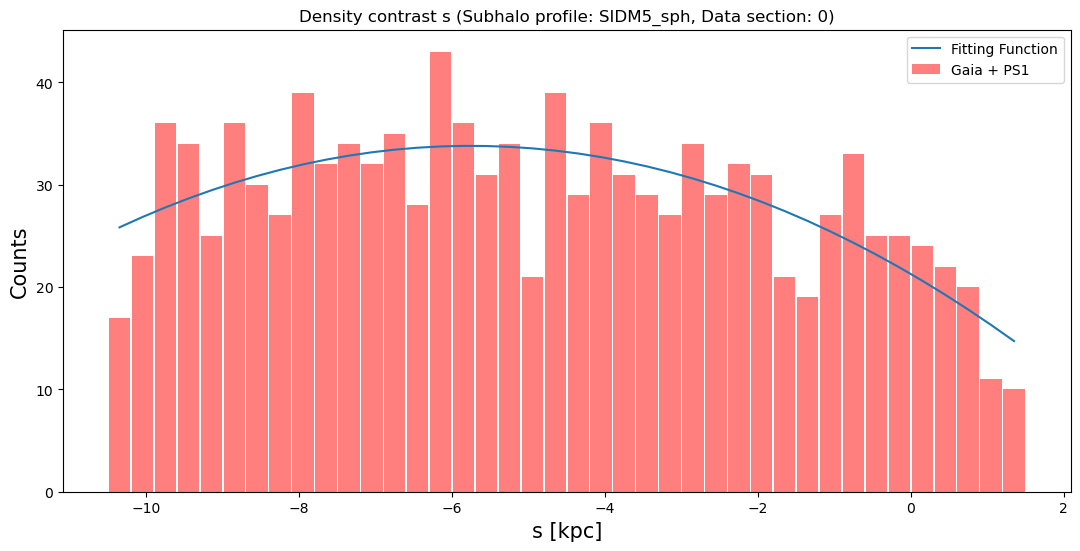

In [33]:
# Plot
plt.figure(figsize=(13,6))
plt.plot(binning_s, quadratic_fit, label='Fitting Function', zorder=2)
plt.bar(binning_s, counts_s, width=0.28,color='r',alpha=0.5,label = 'Gaia + PS1',zorder=1)
plt.title(f'Density contrast s (Subhalo profile: {subhalo_profile}, Data section: {num_data})')
plt.ylabel('Counts',size=15)
plt.xlabel('s [kpc]',size=15)
plt.legend()

# Save and show
plt.savefig(f'../results/{subhalo_profile}/density_contrast_s_section{num_data}.pdf')
plt.show()

In [34]:
# Calculate density contrast
dens_fit_s = counts_s/quadratic_fit

In [35]:
# Calculate the power spectrum 
f_fit, pxx_fit = csd(dens_fit_s,dens_fit_s,fs=1/bin_size_s,scaling='spectrum',nperseg=n_bins)

In [36]:
# Inverse frequency
f_inv_s = 1/f_fit
# print(power)

/tmp/ipykernel_24378/2652177072.py:2: RuntimeWarning: divide by zero encountered in divide
  f_inv_s = 1/f_fit


In [37]:
# Normalisation
norm_factor = binning_s[-1] - binning_s[0]
print('Length of the considered segment =', norm_factor, '[kpc]')

Length of the considered segment = 11.7 [kpc]


In [38]:
# Save values for band plot
x = f_inv_s 
y = 1 * np.sqrt(norm_factor * np.array(pxx_fit))  

# Create data frame and save
data = pd.DataFrame({'x': x, 'y': y})
output_path = f'../results/{subhalo_profile}/power_spectrum_s_data_section{num_data}.csv'
data.to_csv(output_path, index=False)

### Plot and Save Power Spectrum

/tmp/ipykernel_24378/340098675.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,10])


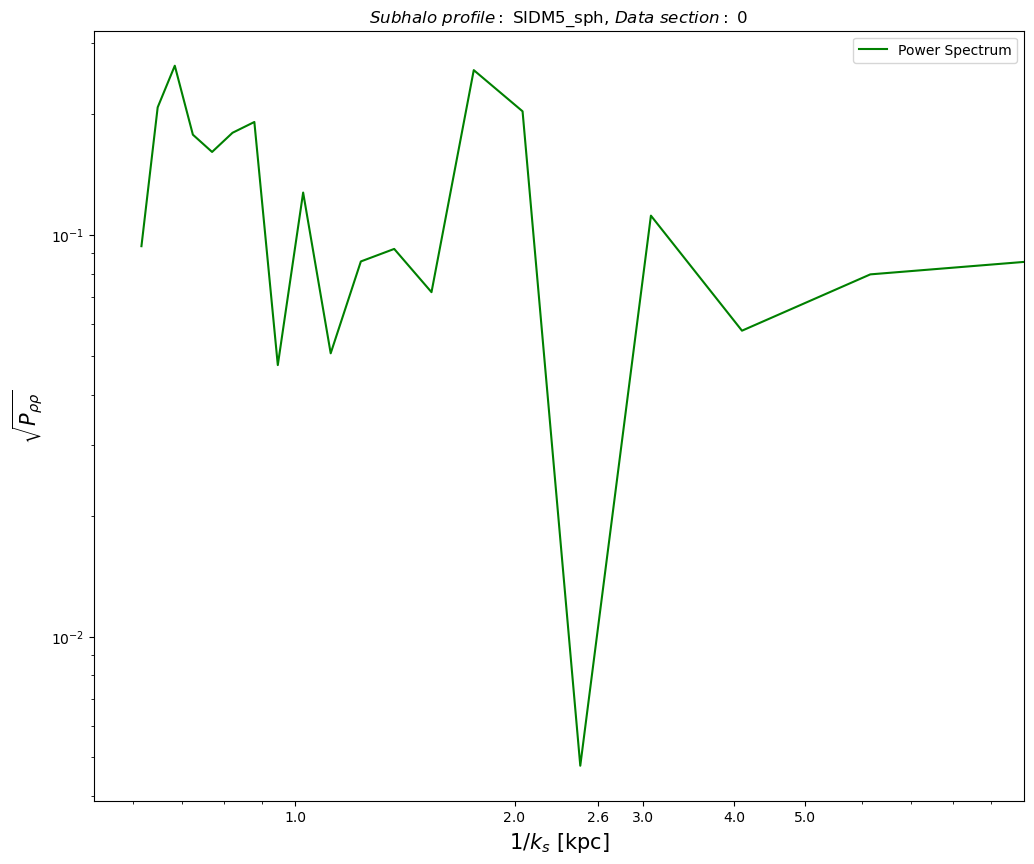

In [39]:
# Plot
plt.figure(figsize=(12,10))
plt.loglog(x, y, color='green', label='Power Spectrum') # adjusted
plt.ylabel(r'$\sqrt{P_{\rho\rho}}$',size=15)
plt.xlabel(r'$1/k_{s}$ [kpc]',size=15)
plt.xlim([0,10])
plt.legend()
plt.title(f'$Subhalo$ $profile:$ {subhalo_profile}, $Data$ $section:$ {num_data}')

ax = plt.gca()
ax.set_xticks([1, 2, 2.6, 3, 4, 5])
ax.xaxis.set_major_formatter(ScalarFormatter())

# Save and show
# plt.savefig(f'../results/{subhalo_profile}/power_spectrum_s_section{num_data}.pdf')
# plt.show()